# Vulnerability Detection in Source Code using deep learning algorithm

- Datasets are available at https://osf.io/d45bw/.
- Distribution of datasets: Training (80%), Validation ( 10%), and Testing ( 10%).
- The dataset contains the source code of 1.27 million functions extracted from open source software and    labelled for possible vulnerabilities using static analysis. 
- Starting with the function name, the raw source code for each function is kept as a variable-length UTF-8 string.Each function has five binary 'vulnerability' labels, one for each of the four most prominent CWEs in our data plus all others:
    - CWE-120 (3.7% of functions)
    - CWE-119 (1.9% of functions)
    - CWE-469 (0.95% of functions)
    - CWE-476 (0.21% of functions)
    - CWE-other (2.7% of functions)
- Each function may have several labelled CWEs.

## Data Pre-processing

Converting HDF5 files to python pickle

In [1]:
import h5py
import pandas as pd

Opening HDF5 file where the data is provided in three HDF5 files corresponding to an 80:10:10 train/validate/test split

In [2]:
data = h5py.File("Draper_VDISC_Dataset/VDISC_train.hdf5",'r') #train dataset 
#data = h5py.File("Draper_VDISC_Dataset/VDISC_validate.hdf5",'r') #validation dataset
#data = h5py.File("Draper_VDISC_Dataset/VDISC_test.hdf5",'r') #test dataset

In [3]:
print(type(data))

<class 'h5py._hl.files.File'>


In [4]:
#printing labeled datasets
print(data.keys())

<KeysViewHDF5 ['CWE-119', 'CWE-120', 'CWE-469', 'CWE-476', 'CWE-other', 'functionSource']>


In [5]:
# List all groups
data.visit(print)

CWE-119
CWE-120
CWE-469
CWE-476
CWE-other
functionSource


Generating a new dataframe from the HDF5 file

In [6]:
data_frame = pd.DataFrame(list(data['functionSource']))

In [7]:
print(data_frame)

                                                         0
0        b'clear_area(int startx, int starty, int xsize...
1        b'ReconstructDuList(Statement* head)\n{\n    S...
2        b'free_speaker(void)\n{\n   if(Lengths)\n     ...
3        b'mlx4_register_device(struct mlx4_dev *dev)\n...
4        b'Parse_Env_Var(void)\n{\n  char *p = getenv("...
...                                                    ...
1019466  b'visitICmpInst(ICmpInst &I) {\n  // We must c...
1019467  b'path_node_delete_chain(path_node * head)\n{\...
1019468  b'addrconf6_start (NMDevice *self)\n{\n\tNMDev...
1019469  b'Next(const SQObjectPtr &refpos, SQObjectPtr ...
1019470  b'EffectHealMaxHealth(SpellEffectIndex /*eff_i...

[1019471 rows x 1 columns]


In [8]:
data_frame['CWE-119']=list(data['CWE-119'])

In [9]:
print(data_frame['CWE-119'])

0          False
1          False
2          False
3          False
4           True
           ...  
1019466    False
1019467    False
1019468    False
1019469    False
1019470    False
Name: CWE-119, Length: 1019471, dtype: bool


In [10]:
data_frame['CWE-120']=list(data['CWE-120'])

In [11]:
print(data_frame['CWE-120'])

0          False
1          False
2          False
3          False
4           True
           ...  
1019466    False
1019467    False
1019468    False
1019469    False
1019470    False
Name: CWE-120, Length: 1019471, dtype: bool


In [12]:
data_frame['CWE-469']=list(data['CWE-469'])

In [13]:
print(data_frame['CWE-469'])

0          False
1          False
2          False
3          False
4          False
           ...  
1019466    False
1019467    False
1019468    False
1019469    False
1019470    False
Name: CWE-469, Length: 1019471, dtype: bool


In [14]:
data_frame['CWE-476']=list(data['CWE-476']) 

In [15]:
print(data_frame['CWE-476'])

0          False
1          False
2          False
3          False
4          False
           ...  
1019466    False
1019467    False
1019468    False
1019469    False
1019470    False
Name: CWE-476, Length: 1019471, dtype: bool


In [16]:
data_frame['CWE-other']=list(data['CWE-other']) 

In [17]:
print(data_frame['CWE-other'])

0          False
1          False
2          False
3          False
4           True
           ...  
1019466    False
1019467    False
1019468    False
1019469    False
1019470    False
Name: CWE-other, Length: 1019471, dtype: bool


In [18]:
data_frame.rename(columns={0:'functionSource'},inplace=True)

In [19]:
data_frame.iloc[0:5,0:]

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,"b'clear_area(int startx, int starty, int xsize...",False,False,False,False,False
1,b'ReconstructDuList(Statement* head)\n{\n S...,False,False,False,False,False
2,b'free_speaker(void)\n{\n if(Lengths)\n ...,False,False,False,False,False
3,b'mlx4_register_device(struct mlx4_dev *dev)\n...,False,False,False,False,False
4,"b'Parse_Env_Var(void)\n{\n char *p = getenv(""...",True,True,False,False,True


In [20]:
data_frame.to_pickle("VDISC_train.pickle")
data_frame.to_pickle("VDISC_validate.pickle")
data_frame.to_pickle("VDISC_test.pickle")

In [22]:
!pip install matplotlib

## Exploratory Data Analysis

## Learning Phase

### Importing libraries

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.utils import class_weight
import pickle

print("Tensorlfow version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Tensorlfow version:  2.1.0
Eager mode:  True
GPU is NOT AVAILABLE


### Setting global variable

In [7]:
# Set the global value
WORDS_SIZE=10000
INPUT_SIZE=500
NUM_CLASSES=2
MODEL_NUM=0
EPOCHS=10

### Importing processed datasets

In [8]:
train=pd.read_pickle("VDISC_train.pickle")
validate=pd.read_pickle("VDISC_validate.pickle")
test=pd.read_pickle("VDISC_test.pickle")
for dataset in [train,validate,test]:
    for col in range(1,6):
        dataset.iloc[:,col] = dataset.iloc[:,col].map({False: 0, True: 1})

# Create source code sdata for tokenization
x_all = train['functionSource']
#x_all = x_all.append(validate['functionSource'])
#x_all = x_all.append(test['functionSource'])

In [26]:
# Overview of the datasets
train.head()

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,"b'clear_area(int startx, int starty, int xsize...",0,0,0,0,0
1,b'ReconstructDuList(Statement* head)\n{\n S...,0,0,0,0,0
2,b'free_speaker(void)\n{\n if(Lengths)\n ...,0,0,0,0,0
3,b'mlx4_register_device(struct mlx4_dev *dev)\n...,0,0,0,0,0
4,"b'Parse_Env_Var(void)\n{\n char *p = getenv(""...",1,1,0,0,1


### Tokenizing the source codes

In [9]:
# Tokenizer with word-level
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=False)
#tokenizer.fit_on_texts(list(x_all))
tokenizer.fit_on_texts([x.decode('utf-8') for x in list(x_all)])
del(x_all)
print('Number of tokens: ',len(tokenizer.word_counts))


Number of tokens:  1094129


In [10]:
# Reducing to top N words
tokenizer.num_words = WORDS_SIZE

In [11]:
# Top 10 words
sorted(tokenizer.word_counts.items(), key=lambda x:x[1], reverse=True)[0:10]

[('if', 3126441),
 ('0', 2106459),
 ('return', 1745333),
 ('i', 1375259),
 ('1', 1186857),
 ('int', 1016932),
 ('null', 975347),
 ('the', 791897),
 ('t', 733766),
 ('n', 716010)]

### Create sequence files from the tokens

In [30]:
## Tokkenizing train data and create matrix
# list_tokenized_train = tokenizer.texts_to_sequences(train['functionSource'])
list_tokenized_train = tokenizer.texts_to_sequences([x.decode('utf-8') for x in train['functionSource']])
x_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, 
                                  maxlen=INPUT_SIZE,
                                  padding='post')
x_train = x_train.astype(np.int64)

In [12]:
## Tokkenizing test data and create matrix
list_tokenized_test = tokenizer.texts_to_sequences([x.decode('utf-8') for x in test['functionSource']])
x_test = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_test = x_test.astype(np.int64)

In [32]:
## Tokkenizing validate data and create matrix
list_tokenized_validate = tokenizer.texts_to_sequences([x.decode('utf-8') for x in validate['functionSource']])
x_validate = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_validate, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_validate = x_validate.astype(np.int64)

In [33]:
# Example data
test.iloc[0:5,1:6]

,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,1,1,0,0,1


### One-Hot-Enconding (OHE) on the datasets

In [14]:
y_train=[]
y_test=[] 
y_validate=[]

for col in range(1,6):
    y_train.append(tf.keras.utils.to_categorical(train.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))
    y_test.append(tf.keras.utils.to_categorical(test.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))
    y_validate.append(tf.keras.utils.to_categorical(validate.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))

In [35]:
# Example data
y_test[0][1:10]

array([[1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int64)

### Model Definition (CNN with Gaussian Noise and 5 Output Splits)


In [36]:
# Create a random weights matrix

random_weights = np.random.normal(size=(WORDS_SIZE, 13),scale=0.01)

In [37]:
# Must use non-sequential model building to create branches in the output layer
inp_layer = tf.keras.layers.Input(shape=(INPUT_SIZE,))
mid_layers = tf.keras.layers.Embedding(input_dim = WORDS_SIZE,
                                    output_dim = 13,
                                    weights=[random_weights],
                                    input_length = INPUT_SIZE)(inp_layer)
mid_layers = tf.keras.layers.Convolution1D(filters=512, kernel_size=(9), padding='same', activation='relu')(mid_layers)
mid_layers = tf.keras.layers.MaxPool1D(pool_size=5)(mid_layers)
mid_layers = tf.keras.layers.Dropout(0.5)(mid_layers)
mid_layers = tf.keras.layers.Flatten()(mid_layers)
mid_layers = tf.keras.layers.Dense(64, activation='relu')(mid_layers)
mid_layers = tf.keras.layers.Dense(16, activation='relu')(mid_layers)
output1 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output2 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output3 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output4 =tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output5 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
model = tf.keras.Model(inp_layer,[output1,output2,output3,output4,output5])

# Define custom optimizers
adam = tf.keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1, decay=0.0, amsgrad=False)

## Compile model with metrics
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
print("CNN model built: ")
model.summary()

CNN model built: 
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 13)      130000      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 500, 512)     60416       embedding[0][0]                  
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 100, 512)     0           conv1d[0][0]                     
____________________________________________________________________________

### Tensorboard Callbacks

In [38]:
## Create TensorBoard callbacks

callbackdir= 'C:\\dump'

tbCallback = tf.keras.callbacks.TensorBoard(log_dir=callbackdir, 
                         histogram_freq=1,
                         embeddings_freq=1,
                         write_graph=True, 
                         write_images=True)

tbCallback.set_model(model)
mld = 'model/model-ALL-{epoch:02d}.hdf5'

## Create best model callback
mcp = tf.keras.callbacks.ModelCheckpoint(filepath=mld, 
                                         monitor="val_loss",
                                         save_best_only=True, 
                                         mode='auto', 
                                         save_freq='epoch', 
                                         verbose=1)

In [ ]:
# for tensorflow above 2.1 the following was expiremented but failed, can further study
# def weighted_categorical_crossentropy(y_true, y_pred, weights):
#     nb_cl = len(weights)
#     final_mask = K.zeros_like(y_pred[:, 0])
#     y_pred_max = K.max(y_pred, axis=1)
#     y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
#     y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
#     for c_p, c_t in product(range(nb_cl), range(nb_cl)):
#         final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
#     return K.categorical_crossentropy(y_pred, y_true) * final_mask

In [ ]:
# from functools import partial
# w1 = np.ones((2, 2))
# w1[1, 0] = 1.
# w1[1, 1] = 5.


# loss1 = partial(weighted_categorical_crossentropy, weights=w1)
# loss2 = partial(weighted_categorical_crossentropy, weights=w1)
# loss3 = partial(weighted_categorical_crossentropy, weights=w1)
# loss4 = partial(weighted_categorical_crossentropy, weights=w1)
# loss5 = partial(weighted_categorical_crossentropy, weights=w1)

# loss_dict = {'dense_2': loss1, 'dense_3': loss2, 'dense_4': loss3, 'dense_5': loss4, 'dense_6': loss5}
# model.compile(loss=loss_dict, optimizer='adam')

### Model Training

In [44]:
# to run this without list or set key issues, change tensorflow to 2.1.0 with python 3.7
# due to lack of time and resources x_train and y_train are limited to 100000

class_weights = [{0: 1., 1: 5.},{0: 1., 1: 5.},{0: 1., 1: 5.},{0: 1., 1: 5.},{0: 1., 1: 5.}]

#class_weights = { 'output1': {0: 1., 1: 5.} , 'output2': {0: 1., 1: 5.},  'output3': {0: 1., 1: 5.}, 'output4': {0: 1., 1: 5.},  'output5': {0: 1., 1: 5.}}

history = model.fit(x = x_train[0:100000],
          y = [y_train[0][0:100000], y_train[1][0:100000], y_train[2][0:100000], y_train[3][0:100000], y_train[4][0:100000]],
          validation_data = (x_validate[0:100000], [y_validate[0][0:100000], y_validate[1][0:100000], y_validate[2][0:100000], y_validate[3][0:100000], y_validate[4][0:100000]]),
          epochs = 40,
          batch_size = 128,
          verbose =2,
          class_weight= class_weights,
          callbacks=[mcp,tbCallback])

with open('history/History-ALL-40EP-CNN', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


Train on 100000 samples, validate on 100000 samples
Epoch 1/40

Epoch 00001: val_loss did not improve from 1.02900
100000/100000 - 347s - loss: 1.0559 - dense_2_loss: 0.2019 - dense_3_loss: 0.2950 - dense_4_loss: 0.0442 - dense_5_loss: 0.1832 - dense_6_loss: 0.3314 - dense_2_accuracy: 0.9702 - dense_3_accuracy: 0.9243 - dense_4_accuracy: 0.9979 - dense_5_accuracy: 0.9905 - dense_6_accuracy: 0.9649 - val_loss: 1.0347 - val_dense_2_loss: 0.1954 - val_dense_3_loss: 0.2862 - val_dense_4_loss: 0.0434 - val_dense_5_loss: 0.1827 - val_dense_6_loss: 0.3270 - val_dense_2_accuracy: 0.9707 - val_dense_3_accuracy: 0.9284 - val_dense_4_accuracy: 0.9979 - val_dense_5_accuracy: 0.9905 - val_dense_6_accuracy: 0.9649
Epoch 2/40

Epoch 00002: val_loss did not improve from 1.02900
100000/100000 - 346s - loss: 1.0433 - dense_2_loss: 0.1987 - dense_3_loss: 0.2901 - dense_4_loss: 0.0435 - dense_5_loss: 0.1831 - dense_6_loss: 0.3277 - dense_2_accuracy: 0.9695 - dense_3_accuracy: 0.9244 - dense_4_accuracy: 0.

Epoch 13/40

Epoch 00013: val_loss improved from 0.93799 to 0.93220, saving model to model/model-ALL-13.hdf5
100000/100000 - 342s - loss: 0.9620 - dense_2_loss: 0.1776 - dense_3_loss: 0.2569 - dense_4_loss: 0.0413 - dense_5_loss: 0.1789 - dense_6_loss: 0.3076 - dense_2_accuracy: 0.9694 - dense_3_accuracy: 0.9196 - dense_4_accuracy: 0.9979 - dense_5_accuracy: 0.9905 - dense_6_accuracy: 0.9608 - val_loss: 0.9322 - val_dense_2_loss: 0.1700 - val_dense_3_loss: 0.2438 - val_dense_4_loss: 0.0402 - val_dense_5_loss: 0.1777 - val_dense_6_loss: 0.3005 - val_dense_2_accuracy: 0.9714 - val_dense_3_accuracy: 0.9233 - val_dense_4_accuracy: 0.9979 - val_dense_5_accuracy: 0.9905 - val_dense_6_accuracy: 0.9629
Epoch 14/40

Epoch 00014: val_loss improved from 0.93220 to 0.92560, saving model to model/model-ALL-14.hdf5
100000/100000 - 342s - loss: 0.9537 - dense_2_loss: 0.1756 - dense_3_loss: 0.2532 - dense_4_loss: 0.0409 - dense_5_loss: 0.1779 - dense_6_loss: 0.3061 - dense_2_accuracy: 0.9684 - dense_3

Epoch 25/40

Epoch 00025: val_loss did not improve from 0.87022
100000/100000 - 346s - loss: 0.8979 - dense_2_loss: 0.1620 - dense_3_loss: 0.2346 - dense_4_loss: 0.0391 - dense_5_loss: 0.1726 - dense_6_loss: 0.2896 - dense_2_accuracy: 0.9651 - dense_3_accuracy: 0.9182 - dense_4_accuracy: 0.9979 - dense_5_accuracy: 0.9905 - dense_6_accuracy: 0.9525 - val_loss: 0.8722 - val_dense_2_loss: 0.1557 - val_dense_3_loss: 0.2250 - val_dense_4_loss: 0.0383 - val_dense_5_loss: 0.1709 - val_dense_6_loss: 0.2824 - val_dense_2_accuracy: 0.9615 - val_dense_3_accuracy: 0.9161 - val_dense_4_accuracy: 0.9979 - val_dense_5_accuracy: 0.9905 - val_dense_6_accuracy: 0.9566
Epoch 26/40

Epoch 00026: val_loss improved from 0.87022 to 0.86022, saving model to model/model-ALL-26.hdf5
100000/100000 - 346s - loss: 0.8920 - dense_2_loss: 0.1609 - dense_3_loss: 0.2312 - dense_4_loss: 0.0392 - dense_5_loss: 0.1715 - dense_6_loss: 0.2888 - dense_2_accuracy: 0.9639 - dense_3_accuracy: 0.9187 - dense_4_accuracy: 0.9979 

Epoch 37/40

Epoch 00037: val_loss improved from 0.81623 to 0.80821, saving model to model/model-ALL-37.hdf5
100000/100000 - 343s - loss: 0.8418 - dense_2_loss: 0.1498 - dense_3_loss: 0.2168 - dense_4_loss: 0.0370 - dense_5_loss: 0.1642 - dense_6_loss: 0.2740 - dense_2_accuracy: 0.9609 - dense_3_accuracy: 0.9209 - dense_4_accuracy: 0.9979 - dense_5_accuracy: 0.9905 - dense_6_accuracy: 0.9487 - val_loss: 0.8082 - val_dense_2_loss: 0.1411 - val_dense_3_loss: 0.2035 - val_dense_4_loss: 0.0365 - val_dense_5_loss: 0.1627 - val_dense_6_loss: 0.2643 - val_dense_2_accuracy: 0.9647 - val_dense_3_accuracy: 0.9249 - val_dense_4_accuracy: 0.9979 - val_dense_5_accuracy: 0.9905 - val_dense_6_accuracy: 0.9570
Epoch 38/40

Epoch 00038: val_loss improved from 0.80821 to 0.80268, saving model to model/model-ALL-38.hdf5
100000/100000 - 343s - loss: 0.8363 - dense_2_loss: 0.1488 - dense_3_loss: 0.2159 - dense_4_loss: 0.0374 - dense_5_loss: 0.1630 - dense_6_loss: 0.2714 - dense_2_accuracy: 0.9610 - dense_3

In [3]:
#!pip install h5py==2.10.0 --force-reinstall --user

In [25]:
history

import h5py
import pandas as pd
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.utils import class_weight
import pickle

print("Tensorlfow version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
#!pip install h5py==2.10.0 --force-reinstall --user
import h5py
# Load model with the lowest loss
from tensorflow.keras.models import load_model
model = load_model('model/model-ALL-38.hdf5')
# model = tf.keras.models.load_model("model/model-ALL-38.hdf5")
results = model.evaluate(x_test, y_test, batch_size=128)
for num in range(0,len(model.metrics_names)):
    print(model.metrics_names[num]+': '+str(results[num]))
# Set the global value
WORDS_SIZE=10000
INPUT_SIZE=500
NUM_CLASSES=2
MODEL_NUM=0
EPOCHS=10
train=pd.read_pickle("VDISC_train.pickle")
validate=pd.read_pickle("VDISC_validate.pickle")
test=pd.read

In [4]:
# import h5py==2.10.0 
# 1 . uninstall h5py from pip and conda
# 2. pip install h5py==2.10.0 
import h5py

### Model Evaluation using Testing Set

In [5]:
# Load model with the lowest loss
from tensorflow.keras.models import load_model
model = load_model('model/model-ALL-38.hdf5')
# model = tf.keras.models.load_model("model/model-ALL-38.hdf5")

In [16]:
results = model.evaluate(x_test, y_test, batch_size=128)
for num in range(0,len(model.metrics_names)):
    print(model.metrics_names[num]+': '+str(results[num]))

1019471/1019471 [==============================] - 732s 718us/sample - loss: 0.4851 - dense_2_loss: 0.1007 - dense_3_loss: 0.1548 - dense_4_loss: 0.0163 - dense_5_loss: 0.0680 - dense_6_loss: 0.1452 - dense_2_accuracy: 0.9614 - dense_3_accuracy: 0.9147 - dense_4_accuracy: 0.9979 - dense_5_accuracy: 0.9905 - dense_6_accuracy: 0.9516
loss: 0.4851082016180739
dense_2_loss: 0.100678734
dense_3_loss: 0.15483238
dense_4_loss: 0.016344808
dense_5_loss: 0.06801847
dense_6_loss: 0.14523205
dense_2_accuracy: 0.96143585
dense_3_accuracy: 0.9146685
dense_4_accuracy: 0.997945
dense_5_accuracy: 0.99049115
dense_6_accuracy: 0.9515876


### Check The Evaluation Metrics

In [20]:
predicted = model.predict(x_test)

In [21]:
pred_test = [[],[],[],[],[]]

for col in range(0,len(predicted)):
    for row in predicted[col]:
        if row[0] >= row[1]:
            pred_test[col].append(0)
        else:
            pred_test[col].append(1)
            
for col in range(0,len(predicted)):
    print(pd.value_counts(pred_test[col]))

0    987034
1     32437
dtype: int64
0    918259
1    101212
dtype: int64
0    1019471
dtype: int64
0    1019471
dtype: int64
0    984919
1     34552
dtype: int64


### Evaluate on the testing set


In [22]:
for col in range(1,6):
    print('\nThis is evaluation for column',col)
    confusion = sklearn.metrics.confusion_matrix(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])
    print(confusion)
    tn, fp, fn, tp = confusion.ravel()
    print('\nTP:',tp)
    print('FP:',fp)
    print('TN:',tn)
    print('FN:',fn)

    ## Performance measure
    print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('Precision: '+ str(sklearn.metrics.precision_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('Recall: '+ str(sklearn.metrics.recall_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=test.iloc[:,col].to_numpy(), y_score=predicted[col-1][:,1])))
    print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=test.iloc[:,col].to_numpy(), y_score=predicted[col-1][:,1])))
    print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    
    


This is evaluation for column 1
[[973952  26233]
 [ 13082   6204]]

TP: 6204
FP: 26233
TN: 973952
FN: 13082

Accuracy: 0.9614358819426938
Precision: 0.1912630637851836
Recall: 0.32168412319817485
F-measure: 0.23989327765210838
Precision-Recall AUC: 0.15171493190560434
AUC: 0.8840041769240439
MCC: 0.22933356942226207

This is evaluation for column 2
[[906359  75093]
 [ 11900  26119]]

TP: 26119
FP: 75093
TN: 906359
FN: 11900

Accuracy: 0.9146684898344337
Precision: 0.25806228510453305
Recall: 0.6869986059601778
F-measure: 0.37518943338767946
Precision-Recall AUC: 0.2765334098052342
AUC: 0.8990997846784375
MCC: 0.38682302064193913

This is evaluation for column 3
[[1017376       0]
 [   2095       0]]

TP: 0
FP: 0
TN: 1017376
FN: 2095

Accuracy: 0.9979450126585259


C:\Users\Softwarica\anaconda3\envs\data-science\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0
Recall: 0.0
F-measure: 0.0
Precision-Recall AUC: 0.019367233400595735
AUC: 0.8914119423193755


C:\Users\Softwarica\anaconda3\envs\data-science\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.0

This is evaluation for column 4
[[1009777       0]
 [   9694       0]]

TP: 0
FP: 0
TN: 1009777
FN: 9694

Accuracy: 0.9904911468791168


C:\Users\Softwarica\anaconda3\envs\data-science\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0
Recall: 0.0
F-measure: 0.0
Precision-Recall AUC: 0.040432200334937704
AUC: 0.7137282645119415


C:\Users\Softwarica\anaconda3\envs\data-science\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.0

This is evaluation for column 5
[[963538  27974]
 [ 21381   6578]]

TP: 6578
FP: 27974
TN: 963538
FN: 21381

Accuracy: 0.9515876371176816
Precision: 0.19037971752720537
Recall: 0.2352730784362817
F-measure: 0.21045895922317673
Precision-Recall AUC: 0.13294576682947157
AUC: 0.8163891744624491
MCC: 0.18688236737576294


In [26]:
history = None
with open('history/History-ALL-40EP-CNN', 'rb') as file_pi:
    history = pickle.load(file_pi)
#     pickle.dump(history.history, file_pi)

In [29]:
history

{'loss': [1.0558950090408326,
  1.0433028445434571,
  1.0344393500900269,
  1.0264688175582886,
  1.017920872001648,
  1.0110375351333618,
  1.0019966765594484,
  0.9958105267715454,
  0.9872454652404785,
  0.9811242122268676,
  0.973685107460022,
  0.9670024846458435,
  0.962037550201416,
  0.9537234657287598,
  0.9494602445220948,
  0.9417812334442138,
  0.9362472374725341,
  0.9286172380256653,
  0.9294122354888916,
  0.9212997193908692,
  0.9163294126319885,
  0.9092585697555542,
  0.9084133329677582,
  0.9040580097389221,
  0.8978834182929992,
  0.8919960156822204,
  0.8861664566230774,
  0.8820902045059205,
  0.8766052731895447,
  0.8747816087341309,
  0.8666291966629028,
  0.8625807343006134,
  0.8599031951522828,
  0.8512396741867065,
  0.8509906742095947,
  0.8466699579238891,
  0.8417702181625366,
  0.8362872507858277,
  0.8291499658966065,
  0.8278373700523376],
 'dense_2_loss': [0.20188747,
  0.19872847,
  0.19572273,
  0.19544628,
  0.19224891,
  0.19214632,
  0.18809018,


In [30]:
history['val_%s'%(model.metrics_names[6])]

[0.9707,
 0.96762,
 0.97131,
 0.96664,
 0.96633,
 0.9681,
 0.97228,
 0.96911,
 0.97099,
 0.96765,
 0.97592,
 0.97323,
 0.97138,
 0.97348,
 0.96907,
 0.9672,
 0.96677,
 0.97217,
 0.97004,
 0.96813,
 0.96859,
 0.96377,
 0.97145,
 0.97107,
 0.96149,
 0.96256,
 0.97466,
 0.96689,
 0.96573,
 0.95568,
 0.9618,
 0.96235,
 0.96413,
 0.96257,
 0.96849,
 0.95876,
 0.96469,
 0.96483,
 0.96799,
 0.95335]

### Plot The Model's Training History

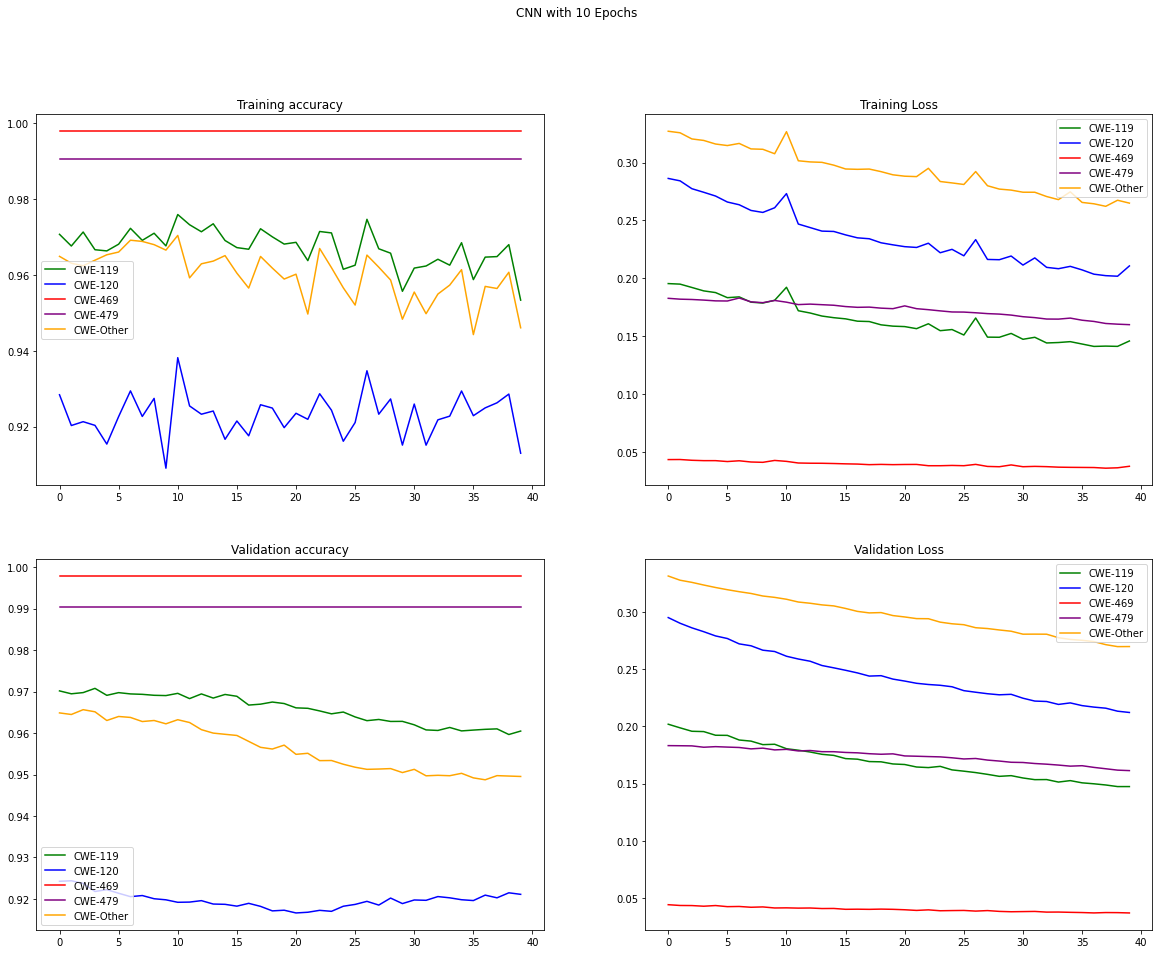

In [34]:
epochs_range = range(len(history[model.metrics_names[1]]))

fig, axs = plt.subplots(2, 2, figsize=(20,15))
fig.suptitle('CNN with 10 Epochs')

axs[0,0].plot(epochs_range, history['val_%s'%(model.metrics_names[6])], 'b', label='CWE-119', color='green')
axs[0,0].plot(epochs_range, history['val_%s'%(model.metrics_names[7])], 'b', label='CWE-120', color='blue')
axs[0,0].plot(epochs_range, history['val_%s'%(model.metrics_names[8])], 'b', label='CWE-469', color='red')
axs[0,0].plot(epochs_range, history['val_%s'%(model.metrics_names[9])], 'b', label='CWE-479', color='purple')
axs[0,0].plot(epochs_range, history['val_%s'%(model.metrics_names[10])], 'b', label='CWE-Other', color='orange')
axs[0,0].set_title('Training accuracy')
axs[0,0].legend()


axs[0,1].plot(epochs_range, history['val_%s'%(model.metrics_names[1])], 'b', label='CWE-119', color='green')
axs[0,1].plot(epochs_range, history['val_%s'%(model.metrics_names[2])], 'b', label='CWE-120', color='blue')
axs[0,1].plot(epochs_range, history['val_%s'%(model.metrics_names[3])], 'b', label='CWE-469', color='red')
axs[0,1].plot(epochs_range, history['val_%s'%(model.metrics_names[4])], 'b', label='CWE-479', color='purple')
axs[0,1].plot(epochs_range, history['val_%s'%(model.metrics_names[5])], 'b', label='CWE-Other', color='orange')
axs[0,1].set_title('Training Loss')
axs[0,1].legend()

axs[1,0].plot(epochs_range, history[model.metrics_names[6]], 'b', label='CWE-119', color='green')
axs[1,0].plot(epochs_range, history[model.metrics_names[7]], 'b', label='CWE-120', color='blue')
axs[1,0].plot(epochs_range, history[model.metrics_names[8]], 'b', label='CWE-469', color='red')
axs[1,0].plot(epochs_range, history[model.metrics_names[9]], 'b', label='CWE-479', color='purple')
axs[1,0].plot(epochs_range, history[model.metrics_names[10]], 'b', label='CWE-Other', color='orange')
axs[1,0].set_title('Validation accuracy')
axs[1,0].legend()


axs[1,1].plot(epochs_range, history[model.metrics_names[1]], 'b', label='CWE-119', color='green')
axs[1,1].plot(epochs_range, history[model.metrics_names[2]], 'b', label='CWE-120', color='blue')
axs[1,1].plot(epochs_range, history[model.metrics_names[3]], 'b', label='CWE-469', color='red')
axs[1,1].plot(epochs_range, history[model.metrics_names[4]], 'b', label='CWE-479', color='purple')
axs[1,1].plot(epochs_range, history[model.metrics_names[5]], 'b', label='CWE-Other', color='orange')
axs[1,1].set_title('Validation Loss')
axs[1,1].legend()
